![GPU Basics Slide 1](img/02_GPU_Basics/Folie1.PNG)

![GPU Basics Slide 2](img/02_GPU_Basics/Folie2.PNG)

![GPU Basics Slide 3](img/02_GPU_Basics/Folie3.PNG)

In [40]:
import inspect
import shutil
import subprocess
import time
import warnings
from collections import defaultdict
from dataclasses import dataclass, field

import cupy
import matplotlib.pyplot as plt
import numpy as np
from numba import cuda, float32, config, njit, vectorize
from numba.core.errors import NumbaPerformanceWarning

config.CUDA_ENABLE_PYNVJITLINK = 1
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

Check if we have a CUDA device :)

In [2]:
# Check if CUDA is available
print(cuda.gpus)

# Maybe needed if we have eg 4 GPUs and distribute the studentns across them
# numba.cuda.select_device( device_id )
# same for cupy

<Managed Device <CUdevice 0>>


OK, let's give it a shot! We use the @vectorize decorator and define the target as cuda. This should automagically run the code on the GPU.

In [37]:
vectorA = np.random.rand(65536).astype(np.float32)
vectorB = np.random.rand(65536).astype(np.float32)

@vectorize([float32(float32, float32)], target='cuda')
def squared_error(d_vectorA, d_vectorB):
    return (d_vectorA - d_vectorB) ** 2

vectorC = squared_error(vectorA, vectorB)
print(f"We do actually get results from teh GPU: {vectorC[0:5]}")

We do actually get results from teh GPU: [0.48185015 0.16692004 0.02076186 0.2887864  0.07044706]


What happened exactly? How does this work under the hood? Let's have a closer look.

![GPU Basics Slide 4](img/02_GPU_Basics/Folie4.PNG)

![GPU Basics Slide 5](img/02_GPU_Basics/Folie5.PNG)

![GPU Basics Slide 6](img/02_GPU_Basics/Folie6.PNG)

![GPU Basics Slide](img/02_GPU_Basics/Folie7.PNG)

![GPU Basics Slide](img/02_GPU_Basics/Folie8.PNG)

![GPU Basics Slide](img/02_GPU_Basics/Folie9.PNG)

![GPU Basics Slide](img/02_GPU_Basics/Folie10.PNG)

OK. Let us use the Nvidia Nsight System (nsys) profiling tool to have a closer look to the timeline as shown in the slide above.

We need to isolate our code into a Python file to be able to execute this easily with nsys:

In [ ]:
%%writefile profiling/cuda_vectorize.py
import numpy as np
from numba import vectorize, float32, cuda

vectorA = np.random.rand(65536).astype(np.float32)
vectorB = np.random.rand(65536).astype(np.float32)

@vectorize([float32(float32, float32)], target='cuda')
def squared_error(d_vectorA, d_vectorB):
    return (d_vectorA - d_vectorB) ** 2

vectorC = squared_error(vectorA, vectorB)
print(f"We do actually get results from teh GPU: {vectorC[0:5]}")


Overwriting cuda_vectorize.py


We can wrap that Python file with the nsys profiler - which is preinstalled here - and dig into the timeline of the code execution.

In [ ]:
!nsys profile -f true -o profiling/cuda_vectorize -t cuda --stats true python3 profiling/cuda_vectorize.py

Try the 'nsys status --environment' command to learn more.

Try the 'nsys status --environment' command to learn more.



/home/azureuser/src/GPU_Part/.venv/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:686: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
[0.28708622 0.3621413  0.10439317 0.00946738 0.00380023]
Generating '/tmp/nsys-report-2143.qdstrm'
[1/6] [========================100%] cuda_vectorize.nsys-rep
[2/6] [========================100%] cuda_vectorize.sqlite
[3/6] Executing 'cuda_api_sum' stats report

 Time (%)  Total Time (ns)  Num Calls  Avg (ns)  Med (ns)  Min (ns)  Max (ns)  StdDev (ns)         Name       
 --------  ---------------  ---------  --------  --------  --------  --------  -----------  ------------------
     43.8           303310          3  101103.3    6292.0      5200    291818     165164.6  cuMemAlloc_v2     
     20.0           138080          2   69040.0   69040.0     41621     96459      38776.3  cuMemcpyHtoD_v2   
     11.2            77190          1   77190.

In fact, we do see the same timeline as in the slides. The big gap between the H2D and the kernel launch is due to
* Python is slow in general
* The function needs be compiled first.

![Nsys profiling of vectorized CUDA kernel](img/01_vectorize_nsys.png)

**ToDo**: Modify the `cuda_vectorize.py` file such that the function is called multiple times. Does the big gap disappear?

Let us dig deeper. What exactly happens on the GPU? How is the calculation distributed among the thousands of cores a GPU has? How can we control this ourselves?

slides threads/grid

In [28]:
vectorA = np.random.rand(65536).astype(np.float32)
vectorB = np.random.rand(65536).astype(np.float32)
vectorC = np.zeros((65536), dtype=np.float32)

@cuda.jit
def squared_error_kernel(vectorA, vectorB, vectorC):
    x = cuda.grid(1)
    vectorC[x] = (vectorA[x] - vectorB[x]) ** 2

d_vectorA = cuda.to_device(vectorA)
d_vectorB = cuda.to_device(vectorB)
d_vectorC = cuda.device_array((65536), dtype=np.float32)
squared_error_kernel[(64),(1024)](d_vectorA, d_vectorB, d_vectorC)
d_vectorC.copy_to_host(vectorC)

print(vectorC[1024:1030])

[0.03245101 0.00085454 0.02855932 0.01089774 0.0108772  0.07373396]


Create the input data. We use a static matrix size of 2048 for today.

In [ ]:
@dataclass
class GPUMatrixProcessor:
  data: dict[str, dict[str, np.ndarray]] = field(default_factory=lambda: defaultdict(dict))
  validation: np.ndarray = field(init=False)
  matrix_size: int = 2048
  benchmark: dict[str, dict[int, float]] = field(default_factory=lambda: defaultdict(dict))
  start: cuda.event = field(default_factory=cuda.event)
  end: cuda.event = field(default_factory=cuda.event)
  implementations: dict[str, callable] = field(default_factory=dict)
  implementations_mem_type: dict[str, str] = field(default_factory=dict)

  def __post_init__(self):
    self.create_data(self.matrix_size)

  def create_data(self, size: int):
    """Creates random matrices of given size."""
    self.matrix_size = size
    for matrix in ["A", "B", "C"]:  # Remove previous matrices for proper GC on the GPU
      [self.data[matrix].pop(mem, None) for mem in ["cpu", "cuda", "cupy"]]
    
    self.data["A"]["cpu"] = np.random.rand(self.matrix_size, self.matrix_size).astype(np.float32)
    self.data["B"]["cpu"] = np.random.rand(self.matrix_size, self.matrix_size).astype(np.float32)
    self.data["C"]["cpu"] = np.zeros((self.matrix_size, self.matrix_size), dtype=np.float32)
    for matrix in ["A", "B", "C"]:
      self.data[matrix]["cuda"] = cuda.to_device(self.data[matrix]["cpu"])
      self.data[matrix]["cupy"] = cupy.asarray(self.data[matrix]["cuda"])
    # Create validation data using numpy 
    self.validation = np.dot(self.data["A"]["cpu"], self.data["B"]["cpu"])

  def add_implementation(self, func: callable, mem_type: str):
    """Adds a new implementation to the processor - need to specify which type of memory to use (cpu, cuda, cupy)."""
    if mem_type not in ["cpu", "cuda", "cupy"]:
      raise ValueError("Memory type must be one of: 'cpu', 'cuda', 'cupy'.")
    self.implementations[func.__name__] = func
    self.implementations_mem_type[func.__name__] = mem_type
    if mem_type in ["cuda", "cupy"]:
      self._create_profiling_version(func.__name__)

  def run_timed_cuda(self, func: callable, *args):
    """Runs a CUDA function and times its execution using CUDA events."""
    self.start.record()
    func(*args)
    self.end.record()
    self.end.synchronize()
    return cuda.event_elapsed_time(self.start, self.end)

  def run_timed_cpu(self, func: callable, *args):
    """Runs a CPU function and times its execution using time module."""
    start = time.perf_counter_ns()
    func(*args)
    end = time.perf_counter_ns()
    return (end - start) / 1e6  # Convert to milliseconds

  def run_implementation(self, name: str, validate: bool = False, mean_time = True, silent=False):
    """Multiplies matrixA and matrixB using specified implementation."""
    func = self.implementations.get(name, None)
    if func is None:
      print(f"Implementation '{name}' not found.")
      return
    
    mem = self.implementations_mem_type[name]
    run_function = self.run_timed_cpu if mem == "cpu" else self.run_timed_cuda
    kernel_ms = run_function(func, self.data["A"][mem], self.data["B"][mem], self.data["C"][mem], self.matrix_size)
    if validate:
      if mem in ["cuda", "cupy"]:
        self.data["C"]["cuda"].copy_to_host(self.data["C"]["cpu"])
      if not np.allclose(self.data["C"]["cpu"], self.validation):
        print(f"Validation of {name} failed: Result does not match expected output.")
    if not silent:
      print(f"First execution of {name} took: {kernel_ms:.3f}ms.")
    if mean_time:
      t_mean = np.mean([run_function(func, self.data["A"][mem], self.data["B"][mem], self.data["C"][mem], self.matrix_size) for _ in range(5)])
      self.benchmark[name][self.matrix_size] = t_mean
      if not silent:
          print(f"Mean execution time of {name} is: {t_mean:.3f}ms.")

  def run_benchmark(self, exclude: list[str] = None):
    """Run all implementations with different matrix sizes and plot their execution speed."""
    for size in [256, 512, 1024, 2048, 4096]:
      self.matrix_size = size
      self.create_data(size)
      exclude = [] if exclude is None else exclude
      [self.run_implementation(name, validate=False, silent=True) for name in self.implementations if name not in exclude]

    self.plot_benchmark()
    self.create_data(2048)  # Reset to default size for further operations

  def plot_benchmark(self):
    """Plots the benchmark results for all implementations."""
    plt.figure(figsize=(10, 6))
    for name, times in self.benchmark.items():
      values = [times[s] for s in [256, 512, 1024, 2048, 4096]]
      plt.plot([256, 512, 1024, 2048, 4096], values, marker='o', label=name)
    plt.title("Matrix Multiplication Benchmark")
    plt.xlabel("Matrix Size (N x N)")
    plt.ylabel("Execution Time (ms)")
    plt.yscale('log')
    plt.legend()
    plt.grid()
    plt.show()

  def _create_profiling_version(self, func_name: str):
    """Creates a profiling version of the given function."""
    with open("profiling/template_profiling.py", "rb") as src, open(f"profiling/profiling_{func_name}.py", "wb") as dst:
      shutil.copyfileobj(src, dst)
    with open(f"profiling/profiling_{func_name}.py", "a") as prof_file:
      for name, obj in globals().items():
        if func_name in name :
            prof_file.write(f"\n{inspect.getsource(obj)}\n")
      prof_file.write(f"matrix_processor.add_implementation({func_name}, mem_type=\"cuda\")\n")
      prof_file.write(f"matrix_processor.run_implementation(\"{func_name}\", validate=False, mean_time=False)\n")
  
  def profile_gpu_implementation(self, name: str, debug=False):
      """Use Nvidia tools to profile the implementation."""
      result = subprocess.run(["ncu", f"-o ncu_{name}", "python", f"profiling/profiling_{name}.py"], capture_output=True, text=True)
      print(f"Check profiling/ncu_{name}.ncu-rep for profiling results.")
      if debug:
          print(f"{result.stdout}\n{result.stderr}")

#Our global object to play around with the matrices
matrix_processor = GPUMatrixProcessor()

In [9]:
@njit
def numba_matmul_basic(matrixA, matrixB, matrixC, size):
    """Perform square matrix multiplication of matrixC = matrixA * matrixB using Numba."""
    for y in range(size):
        for x in range(size):
            tmp = 0.0
            for k in range(size):
                tmp += matrixA[y, k] * matrixB[k, x]
            matrixC[y, x] = tmp

matrix_processor.add_implementation(numba_matmul_basic, mem_type="cpu")
matrix_processor.run_implementation("numba_matmul_basic", validate=True, mean_time=False)  # It takes a long time

First execution of numba_matmul_basic took: 61632.885ms.


In [ ]:
def numpy_dot(matrixA, matrixB, matrixC, size):
    """Perform square matrix multiplication of matrixC = matrixA * matrixB using Numpy dot."""
    np.dot(matrixA, matrixB, out=matrixC)

matrix_processor.add_implementation(numpy_dot, mem_type="cpu")
matrix_processor.run_implementation("numpy_dot", validate=True)

First execution of numpy_2 took: 76.867ms.
Mean execution time of numpy_2 is: 55.920ms.


In [14]:
@cuda.jit
def cuda_matmul_gpu_basic(matrixA, matrixB, matrixC, size):
    """Perform square matrix multiplication of matrixC = matrixA * matrixB."""
    x, y = cuda.grid(2)

    tmp = float32(0.0)
    for k in range(size):
        tmp += matrixA[y, k] * matrixB[k, x]
    matrixC[y, x] = tmp


def matmul_gpu_basic(matrixA, matrixB, matrixC, size):
    cuda_matmul_gpu_basic[(size//32, size//32), (32,32)](matrixA, matrixB, matrixC, size)

matrix_processor.add_implementation(matmul_gpu_basic, mem_type="cuda")
matrix_processor.run_implementation("matmul_gpu_basic", validate=True)


First execution of matmul_gpu_basic took: 233.702ms.
Mean execution time of matmul_gpu_basic is: 112.615ms.


In [15]:
matrix_processor.profile_gpu_implementation("matmul_gpu_basic")

Check ncu_matmul_gpu_basic.ncu-rep for profiling results.


In [16]:
@cuda.jit
def cuda_matmul_shared_mem(matrixA, matrixB, matrixC, size):
    """Perform square matrix multiplication of matrixC = matrixA * matrixB."""
    smem = cuda.shared.array(0, dtype=float32)
    sA = smem[:1024].reshape(32, 32)
    sB = smem[1024 : 2048].reshape(32, 32)
   
    x, y = cuda.grid(2)
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = float32(0.0)
    for i in range(size//32):
        # Preload data into shared memory
        sA[ty, tx] = matrixA[y, tx + i * 32]
        sB[ty, tx] = matrixB[ty + i * 32, x]
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(32):
            tmp += sA[ty, j] * sB[j, tx]

        cuda.syncthreads()

    matrixC[y, x] = tmp


def matmul_shared_mem(matrixA, matrixB, matrixC, size):
    """Use 8192 bytes of shared memory (32x32 tile size) for matrix multiplication."""
    cuda_matmul_shared_mem[(size//32, size//32), (32,32), 0, 8192](matrixA, matrixB, matrixC, size)

matrix_processor.add_implementation(matmul_shared_mem, mem_type="cuda")
matrix_processor.run_implementation("matmul_shared_mem", validate=True)

First execution of matmul_shared_mem took: 506.985ms.
Mean execution time of matmul_shared_mem is: 43.098ms.


In [17]:
@cuda.jit
def cuda_matmul_4results(matrixA, matrixB, matrixC, size):
    """Perform square matrix multiplication of matrixC = matrixA * matrixB."""
    smem = cuda.shared.array(0, dtype=float32)
    sA = smem[:1024].reshape(32, 32)
    sB = smem[1024 : 2048].reshape(32, 32)
   
    x = cuda.blockIdx.x * 32 + cuda.threadIdx.x
    y = cuda.blockIdx.y * 32 + cuda.threadIdx.y
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    tmp = cuda.local.array(4, float32)
    for i in range(size//32):
        # Preload data into shared memory
        sA[ty, tx] = matrixA[y, tx + i * 32]
        sA[ty+8, tx] = matrixA[y+8, tx + i * 32]
        sA[ty+16, tx] = matrixA[y+16, tx + i * 32]
        sA[ty+24, tx] = matrixA[y+24, tx + i * 32]
        sB[ty, tx] = matrixB[ty + i * 32, x]
        sB[ty+8, tx] = matrixB[ty+8 + i * 32, x]
        sB[ty+16, tx] = matrixB[ty+16 + i * 32, x]
        sB[ty+24, tx] = matrixB[ty+24 + i * 32, x]
        cuda.syncthreads()

        # Computes 4 partial product on the shared memory
        for j in range(32):
            tmp[0] += sA[ty, j] * sB[j, tx]
            tmp[1] += sA[ty+8, j] * sB[j, tx]
            tmp[2] += sA[ty+16, j] * sB[j, tx]
            tmp[3] += sA[ty+24, j] * sB[j, tx]

        cuda.syncthreads()

    matrixC[y, x] = tmp[0]
    matrixC[y+8, x] = tmp[1]
    matrixC[y+16, x] = tmp[2]
    matrixC[y+24, x] = tmp[3]


def matmul_4results(matrixA, matrixB, matrixC, size):
    """Use 8192 bytes of shared memory (32x32 tile size) for matrix multiplication."""
    cuda_matmul_4results[(size//32, size//32), (32,32//4), 0, 8192](matrixA, matrixB, matrixC, size)

matrix_processor.add_implementation(matmul_4results, mem_type="cuda")
matrix_processor.run_implementation("matmul_4results", validate=True)

First execution of matmul_4results took: 554.590ms.
Mean execution time of matmul_4results is: 32.545ms.


In [18]:
@cuda.jit
def cuda_matmul_4tiles(matrixA, matrixB, matrixC, size):
    """Perform square matrix multiplication of matrixC = matrixA * matrixB."""
    smem = cuda.shared.array(0, dtype=float32)
    sAupper = smem[:1024].reshape(32, 32)
    sAlower = smem[1024 : 2048].reshape(32, 32)
    sBleft = smem[2048 : 3072].reshape(32, 32)
    sBright = smem[3072 : 4096].reshape(32, 32)
   
    x = cuda.blockIdx.x * 64 + cuda.threadIdx.x
    y = cuda.blockIdx.y * 64 + cuda.threadIdx.y
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    tmpUpperLeft = cuda.local.array(4, float32)
    tmpUpperRight = cuda.local.array(4, float32)
    tmpLowerLeft = cuda.local.array(4, float32)
    tmpLowerRight = cuda.local.array(4, float32)
    for i in range(size//32):
        # Preload data into shared memory
        sAupper[ty, tx] = matrixA[y, tx + i * 32]
        sAupper[ty+8, tx] = matrixA[y+8, tx + i * 32]
        sAupper[ty+16, tx] = matrixA[y+16, tx + i * 32]
        sAupper[ty+24, tx] = matrixA[y+24, tx + i * 32]
        sAlower[ty, tx] = matrixA[y+32, tx + i * 32]
        sAlower[ty+8, tx] = matrixA[y+40, tx + i * 32]
        sAlower[ty+16, tx] = matrixA[y+48, tx + i * 32]
        sAlower[ty+24, tx] = matrixA[y+56, tx + i * 32]
        sBleft[ty, tx] = matrixB[ty + i * 32, x]
        sBleft[ty+8, tx] = matrixB[ty+8 + i * 32, x]
        sBleft[ty+16, tx] = matrixB[ty+16 + i * 32, x]
        sBleft[ty+24, tx] = matrixB[ty+24 + i * 32, x]
        sBright[ty, tx] = matrixB[ty + i * 32, x+32]
        sBright[ty+8, tx] = matrixB[ty+8 + i * 32, x+32]
        sBright[ty+16, tx] = matrixB[ty+16 + i * 32, x+32]
        sBright[ty+24, tx] = matrixB[ty+24 + i * 32, x+32]
        cuda.syncthreads()

        # Computes 4 partial products on 4 tiles (so total of 16) on the shared memory
        for j in range(32):
            tmpUpperLeft[0] += sAupper[ty, j] * sBleft[j, tx]
            tmpUpperLeft[1] += sAupper[ty+8, j] * sBleft[j, tx]
            tmpUpperLeft[2] += sAupper[ty+16, j] * sBleft[j, tx]
            tmpUpperLeft[3] += sAupper[ty+24, j] * sBleft[j, tx]
            tmpUpperRight[0] += sAupper[ty, j] * sBright[j, tx]
            tmpUpperRight[1] += sAupper[ty+8, j] * sBright[j, tx]
            tmpUpperRight[2] += sAupper[ty+16, j] * sBright[j, tx]
            tmpUpperRight[3] += sAupper[ty+24, j] * sBright[j, tx]
            tmpLowerRight[0] += sAlower[ty, j] * sBright[j, tx]
            tmpLowerRight[1] += sAlower[ty+8, j] * sBright[j, tx]
            tmpLowerRight[2] += sAlower[ty+16, j] * sBright[j, tx]
            tmpLowerRight[3] += sAlower[ty+24, j] * sBright[j, tx]
            tmpLowerLeft[0] += sAlower[ty, j] * sBleft[j, tx]
            tmpLowerLeft[1] += sAlower[ty+8, j] * sBleft[j, tx]
            tmpLowerLeft[2] += sAlower[ty+16, j] * sBleft[j, tx]
            tmpLowerLeft[3] += sAlower[ty+24, j] * sBleft[j, tx]
        cuda.syncthreads()

    matrixC[y, x] = tmpUpperLeft[0]
    matrixC[y+8, x] = tmpUpperLeft[1]
    matrixC[y+16, x] = tmpUpperLeft[2]
    matrixC[y+24, x] = tmpUpperLeft[3]
    matrixC[y, x+32] = tmpUpperRight[0]
    matrixC[y+8, x+32] = tmpUpperRight[1]
    matrixC[y+16, x+32] = tmpUpperRight[2]
    matrixC[y+24, x+32] = tmpUpperRight[3]
    matrixC[y+32, x] = tmpLowerLeft[0]
    matrixC[y+40, x] = tmpLowerLeft[1]
    matrixC[y+48, x] = tmpLowerLeft[2]
    matrixC[y+56, x] = tmpLowerLeft[3]
    matrixC[y+32, x+32] = tmpLowerRight[0]
    matrixC[y+40, x+32] = tmpLowerRight[1]
    matrixC[y+48, x+32] = tmpLowerRight[2]
    matrixC[y+56, x+32] = tmpLowerRight[3]


def matmul_4tiles(matrixA, matrixB, matrixC, size):
    """Use 8192 bytes of shared memory (32x32 tile size) for matrix multiplication."""
    cuda_matmul_4tiles[(size//64, size//64), (32,32//4), 0, 16384](matrixA, matrixB, matrixC, size)

matrix_processor.add_implementation(matmul_4tiles, mem_type="cuda")
matrix_processor.run_implementation("matmul_4tiles", validate=True)

First execution of matmul_4tiles took: 1284.793ms.
Mean execution time of matmul_4tiles is: 17.098ms.


Try to use what is already there!
Show cuda ecosystem

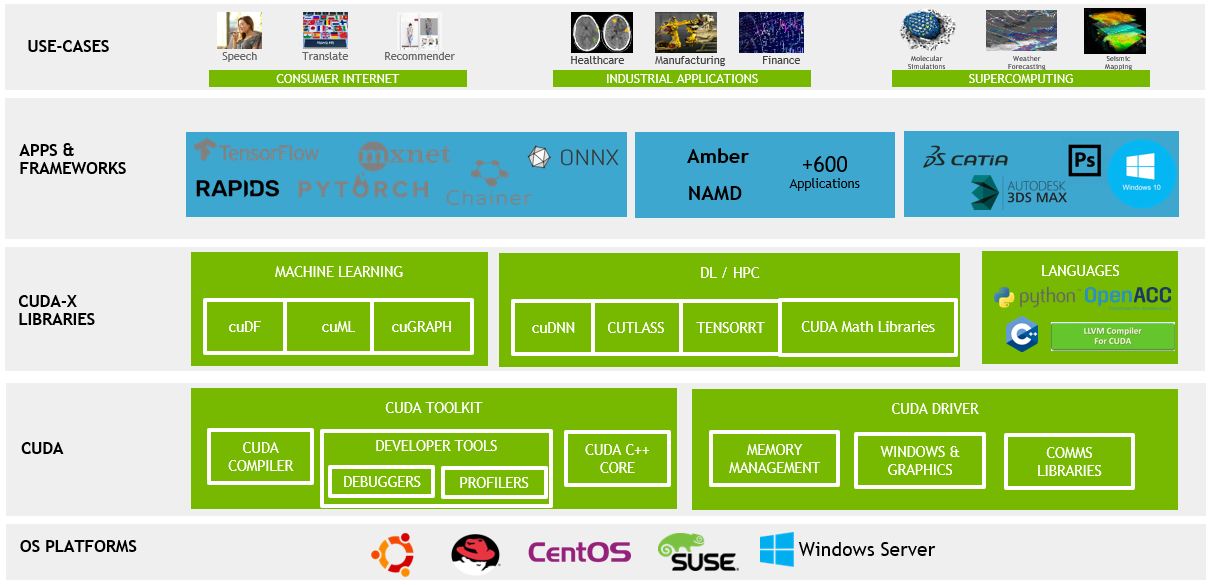

In [19]:
def matmul_cupy(matrixA, matrixB, matrixC, size):
    """Use cupy.dot (which is using CuBLAS unde rthe hood) to have the most efficient implementation."""
    cupy.dot(matrixA, matrixB, out=matrixC)

matrix_processor.add_implementation(matmul_cupy, mem_type="cupy")
matrix_processor.run_implementation("matmul_4tiles", validate=True)

First execution of matmul_4tiles took: 17.198ms.
Mean execution time of matmul_4tiles is: 17.021ms.


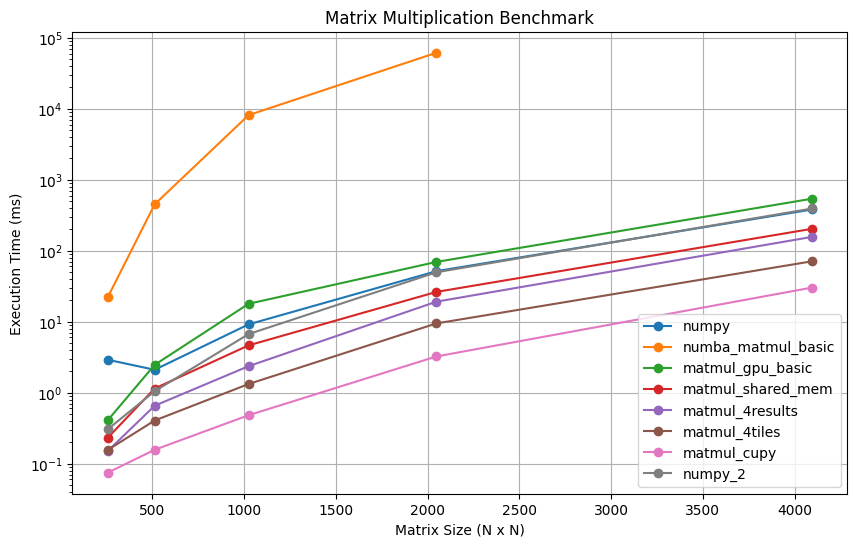

In [32]:
#matrix_processor.run_benchmark()  # Running numba_matmul_basic N times will take a long time - talking hours!
matrix_processor.benchmark["numba_matmul_basic"][256] = 22
matrix_processor.benchmark["numba_matmul_basic"][512] = 451
matrix_processor.benchmark["numba_matmul_basic"][1024] = 8140
matrix_processor.benchmark["numba_matmul_basic"][2048] = 61632
matrix_processor.benchmark["numba_matmul_basic"][4096] = None

matrix_processor.run_benchmark(exclude=["numba_matmul_basic"])